In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("train.csv")

In [3]:
# Conver to DateTime object

df["date"] = pd.to_datetime(pd.to_datetime(df["OPERATIONDATE"]).dt.date)

## Aggregation

In [4]:
df = (pd.DataFrame(df.groupby(["date", "CASHPOINTID"])["AMT_SCALED"].sum())
      .reset_index()
      .rename({"CASHPOINTID": "ATM_id", "AMT_SCALED": "Amount"}, axis=1))

## Visualization

---

Visualize single ATM cashflow during 60 days

<AxesSubplot:xlabel='date', ylabel='Amount'>

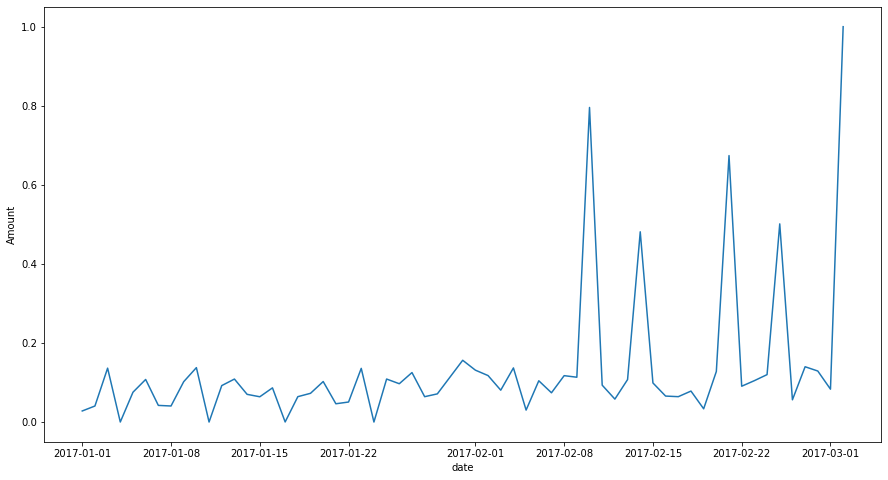

In [5]:
# Plot time series

plt.figure(figsize=(15,8))


sns.lineplot(data=df[df["ATM_id"] == 0][:60], x="date", y="Amount")

In [6]:
df.head()

,date,ATM_id,Amount
0,2017-01-01,0,0.027997
1,2017-01-01,1,0.014108
2,2017-01-01,2,0.009077
3,2017-01-01,3,0.002922
4,2017-01-01,4,0.004330


## TS decomposition

---

The plot represents TS decomposition of cashflow for one ATM

In [15]:
result = sm.tsa.seasonal_decompose(df[df["ATM_id"] == 0]["Amount"], period=30)

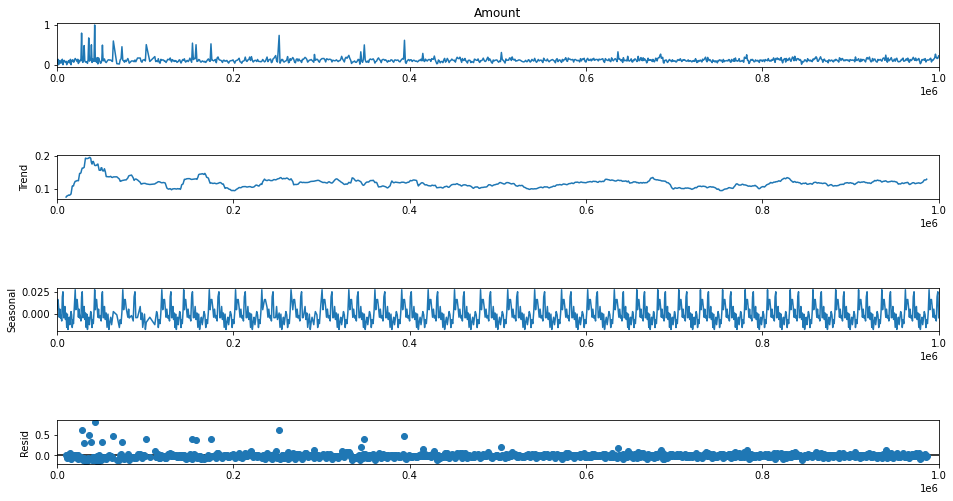

In [16]:
fig = result.plot()

fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Perform TS stationarity test

---

We can use Augmented-Dickey-Fuller (ADF) test to test if our time series exhibits stationarity.

> Note: This process takes considerable time and recourses. So, I will perform this test only for one ATM


It turns out that P-Value less than $\alpha=0.05$, meaning that we reject the hypothesis about time series stationarity and conclude that our time series for one ATM is non-stationarity.

In [17]:
res = sm.tsa.adfuller(df[df["ATM_id"] == 0]["Amount"],regression='ct')

print('p-value:{}'.format(res[1]))

p-value:2.0234833157233766e-06


## Plot Autocorrelation and Partial Autocorrelation

---

These plots will help to choose optimal number of lags for AR and MA process

The plots indicates that optimal number for lag is 1. Other lags seems insignificant.

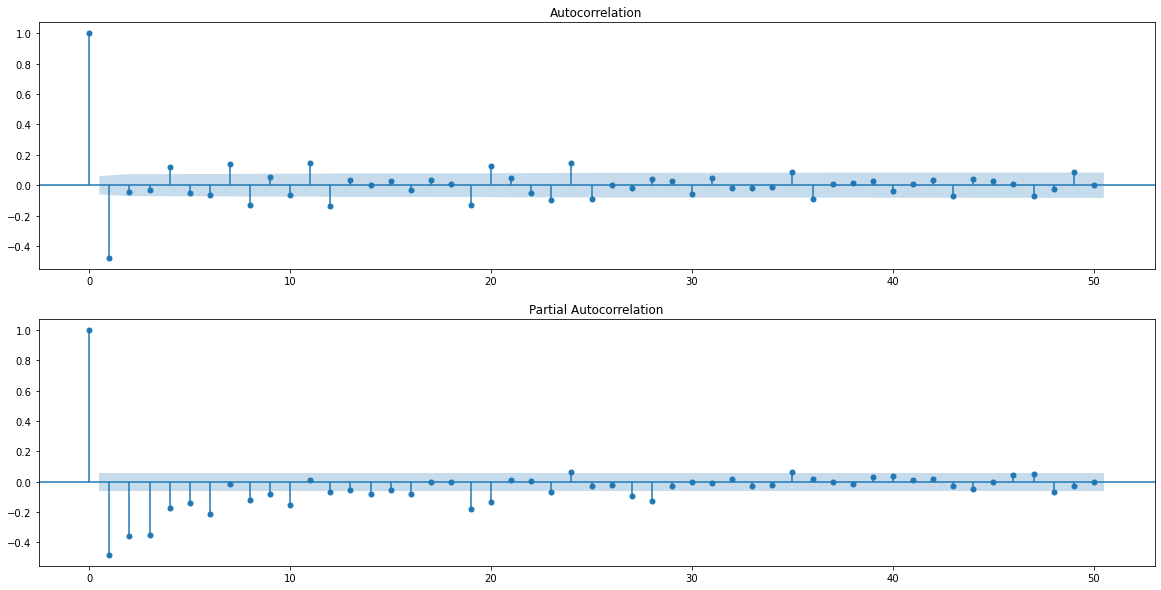

In [18]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

fig = sm.graphics.tsa.plot_acf(df[df["ATM_id"] == 0]["Amount"].diff().dropna(), lags=50, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(df[df["ATM_id"] == 0]["Amount"].diff().dropna(), lags=50, ax=ax[1])

plt.show()

### Perform optimal lag number search

---

This is to find optimal lag number. We use here automatic order selection for ARIMA process. The judgment criteria for lag selection is Akaike Information Criteria.

> Note: The search process is done for one ATM as if we perform it for all ATM it will take much time.

After search, we found that ARIMA(7,1,5) is the best model. However, due to limited computational recourse we will train only ARIMA(1,1,1)

In [20]:
resDiff = sm.tsa.arma_order_select_ic(df[df["ATM_id"] == 0]["Amount"],
                                      max_ar=7,
                                      max_ma=7,
                                      ic='aic',
                                      trend='c')

print('ARMA(p,q) =', resDiff['aic_min_order'],'is the best.')

/home/okroshiashvili/miniconda3/envs/learning/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/okroshiashvili/miniconda3/envs/learning/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/okroshiashvili/miniconda3/envs/learning/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/okroshiashvili/miniconda3/envs/learning/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/okroshiashvili/miniconda3/envs/learning/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: 

ARMA(p,q) = (7, 5) is the best.


# Feature Extraction

## National Holidays

In [25]:
new_year = pd.DataFrame({'new_year' : pd.to_datetime(["2017-01-01", "2018-01-01", "2019-01-01"])})

christmas = pd.DataFrame({'christmas' : pd.to_datetime(["2017-01-07", "2018-01-07", "2019-01-07"])})

epiphany = pd.DataFrame({'epiphany' : pd.to_datetime(["2017-01-19", "2018-01-19", "2019-01-19"])})

mothers_day = pd.DataFrame({'mothers_day' : pd.to_datetime(["2017-03-03", "2018-03-03", "2019-03-03"])})

women_day = pd.DataFrame({'women_day' : pd.to_datetime(["2017-03-08", "2018-03-08", "2019-03-08"])})

easter = pd.DataFrame({'easter' : pd.to_datetime(["2017-04-16", "2018-04-08", "2019-04-28"])})

independence = pd.DataFrame({'independence' : pd.to_datetime(["2017-05-26", "2018-05-26", "2019-05-26"])})

assumption = pd.DataFrame({'assumption' : pd.to_datetime(["2017-08-28", "2018-08-28", "2019-08-28"])})

orthodox_festival = pd.DataFrame({'orthodox_festival' : pd.to_datetime(["2017-10-14", "2018-10-14", "2019-10-14"])})

george_day = pd.DataFrame({'george_day' : pd.to_datetime(["2017-11-23", "2018-11-23", "2019-11-23"])})

In [26]:
holidays = pd.concat([new_year, christmas, epiphany, mothers_day, women_day,
                      easter, independence, assumption, orthodox_festival, george_day])

### Add week days

In [27]:
df["week_days"] = df['date'].dt.day_name()

In [28]:
df["weekends"] = np.where(((df["week_days"] == "Sunday") | (df["week_days"] == "Saturday")), 1, 0)

## Add holidays

In [29]:
df["new_year"] = np.where(df["date"].isin(holidays["new_year"]), 1, 0)

df["christmas"] = np.where(df["date"].isin(holidays["christmas"]), 1, 0)

df["epiphany"] = np.where(df["date"].isin(holidays["epiphany"]), 1, 0)

df["mothers_day"] = np.where(df["date"].isin(holidays["mothers_day"]), 1, 0)

df["women_day"] = np.where(df["date"].isin(holidays["women_day"]), 1, 0)

df["easter"] = np.where(df["date"].isin(holidays["easter"]), 1, 0)

df["independence"] = np.where(df["date"].isin(holidays["independence"]), 1, 0)

df["assumption"] = np.where(df["date"].isin(holidays["assumption"]), 1, 0)

df["orthodox_festival"] = np.where(df["date"].isin(holidays["orthodox_festival"]), 1, 0)

df["george_day"] = np.where(df["date"].isin(holidays["george_day"]), 1, 0)

# Train-Test split

---

We decided to split data as a train set up to `2018-12-31` and afterward as a tests set. This leaves us with `687,122` training and `313,073` testing points

In [30]:
df

,date,ATM_id,Amount,week_days,weekends,new_year,christmas,epiphany,mothers_day,women_day,easter,independence,assumption,orthodox_festival,george_day
0,2017-01-01,0,0.027997,Sunday,1,1,0,0,0,0,0,0,0,0,0
1,2017-01-01,1,0.014108,Sunday,1,1,0,0,0,0,0,0,0,0,0
2,2017-01-01,2,0.009077,Sunday,1,1,0,0,0,0,0,0,0,0,0
3,2017-01-01,3,0.002922,Sunday,1,1,0,0,0,0,0,0,0,0,0
4,2017-01-01,4,0.004330,Sunday,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000986,2019-12-31,1337,1.000000,Tuesday,0,0,0,0,0,0,0,0,0,0,0
1000987,2019-12-31,1338,0.463625,Tuesday,0,0,0,0,0,0,0,0,0,0,0
1000988,2019-12-31,1339,0.472067,Tuesday,0,0,0,0,0,0,0,0,0,0,0
1000989,2019-12-31,1340,0.250196,Tuesday,0,0,0,0,0,0,0,0,0,0,0


In [31]:
data = df.sort_values(by="date").copy(deep=True)

In [32]:
atm_ids = data[["date", "ATM_id"]]

In [33]:
data = data.drop(["week_days", "ATM_id"], axis=1)

In [34]:
train = data[data["date"] < "2018-12-31"]

test = data[data["date"] > "2018-12-31"]

# ARIMA

In [35]:
model = sm.tsa.statespace.SARIMAX(endog=train.iloc[:, 1].values,
                                  order=(1,1,1),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

In [36]:
res = model.fit()

In [37]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               687122
Model:               SARIMAX(1, 1, 1)   Log Likelihood              509941.807
Date:                Thu, 17 Dec 2020   AIC                       -1019877.614
Time:                        20:50:33   BIC                       -1019843.293
Sample:                             0   HQIC                      -1019868.025
                             - 687122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0147      0.001     20.214      0.000       0.013       0.016
ma.L1         -0.9613      0.000  -4120.948      0.000      -0.962      -0.961
sigma2         0.0133   1.65e-06   8037.273      0.000       0.013       0.013
===================================================================================
Ljung-Box (Q):                     1035.63   Jarque-Bera (JB):        4043638542.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             7.73
Prob(H) (two-sided):                  0.00   Kurtosis:                       378.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot correlogram

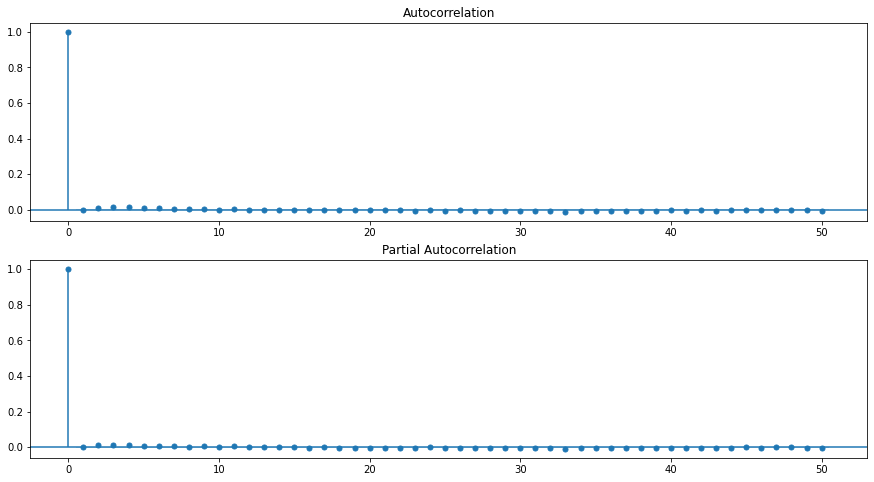

In [38]:
residuals = res.resid

fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [40]:
pred = res.predict(0, 313073)[1:]

print('ARIMAX model MSE:{}'.format(mean_squared_error(test.iloc[:, 1], pred)))

ARIMAX model MSE:0.016276128830422405


In [41]:
np.sqrt(mean_squared_error(test.iloc[:, 1], pred))

0.12757793238026083

## Bar chart for the first 30 actual vs predicted values

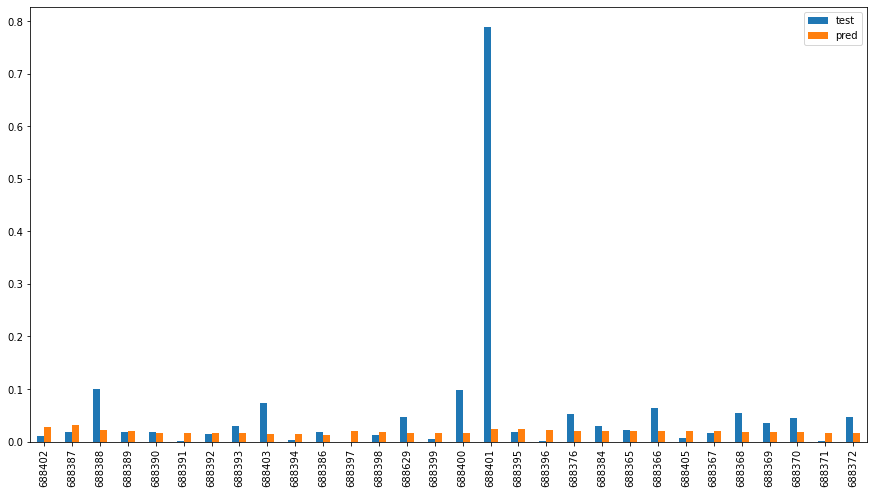

In [42]:
pd.DataFrame({'test':test.iloc[:, 1][:30],'pred':pred[:30]}).plot.bar(figsize=(15,8));plt.show()

## Plot actual vs predicted

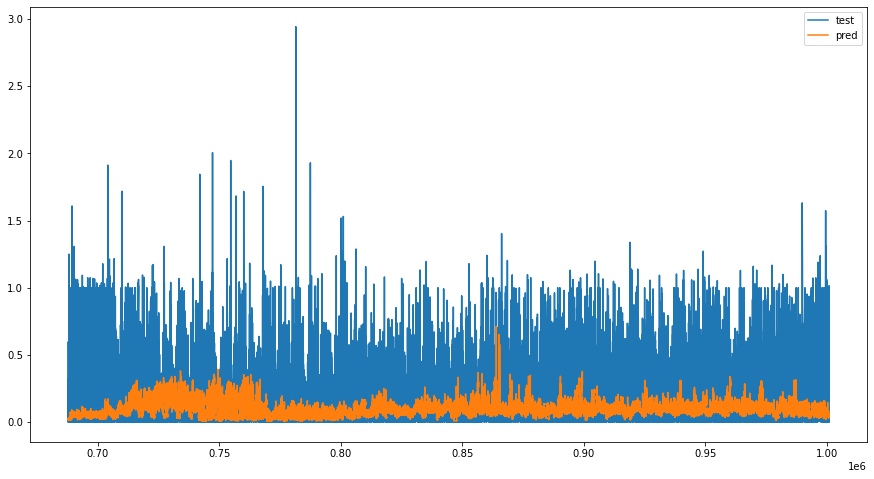

In [43]:
pd.DataFrame({'test':test.iloc[:, 1],'pred':pred}).plot(figsize=(15,8));plt.show()

## Model diagnostics plot

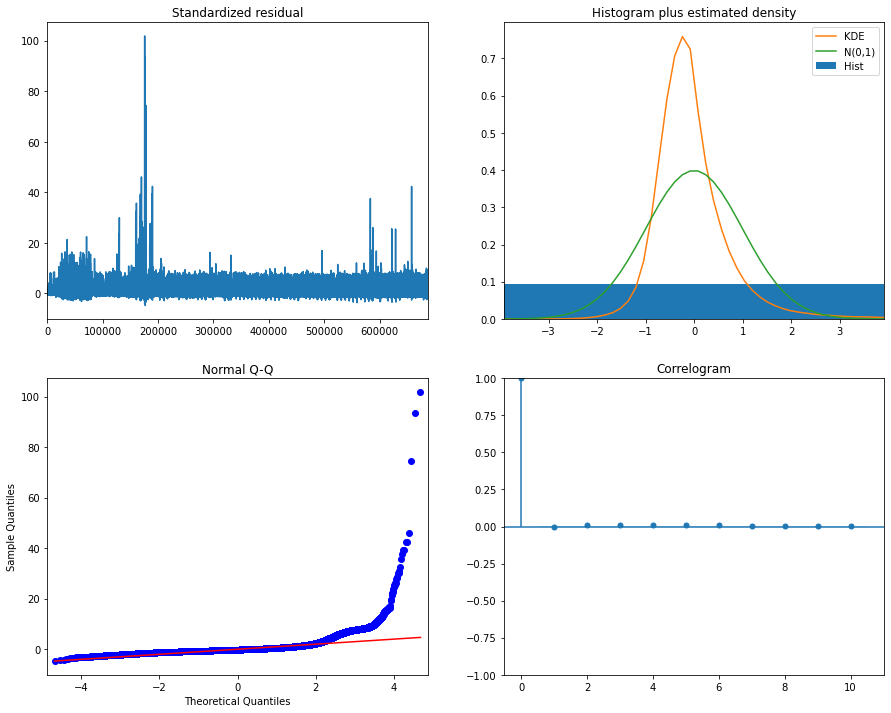

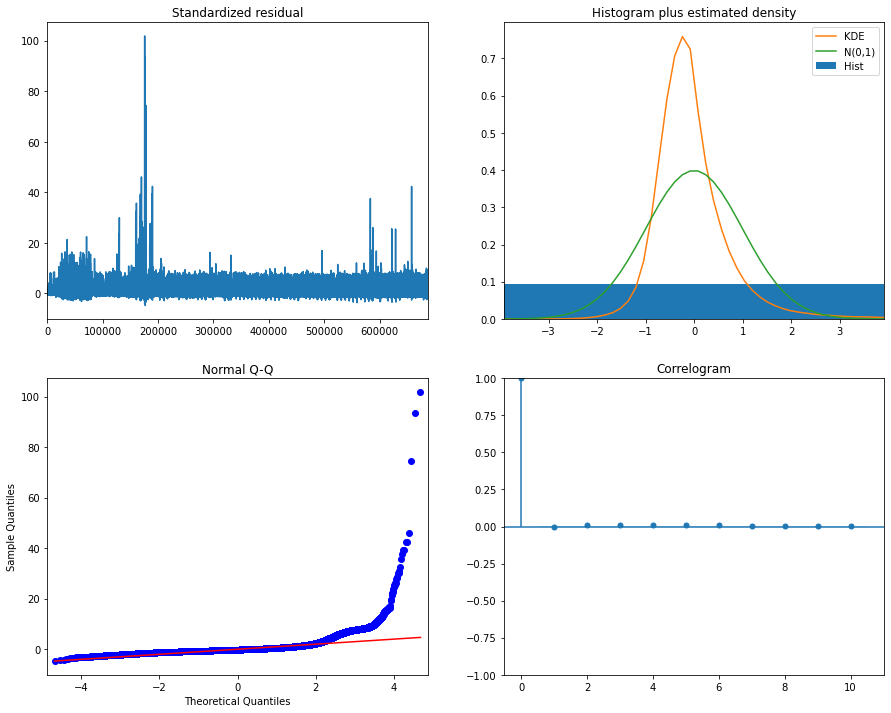

In [45]:
res.plot_diagnostics(figsize=(15, 12))

# Submission

In [49]:
pd.DataFrame(res.predict(0, 41633)[1:]).rename({0: "PREDICTION"}, axis=1).to_csv("Submission_ARIMA(1,1,1).csv", index=False)

In [50]:
pd.DataFrame(res.predict(0, 41633)[1:]).rename({0: "PREDICTION"}, axis=1)

,PREDICTION
0,0.028203
1,0.031256
2,0.021300
3,0.020813
4,0.016246
...,...
41628,0.118475
41629,0.116807
41630,0.161889
41631,0.144690
